# Data analysis posterior

Building classes for TimeSeries data and FrequencySeries data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import utils
utils.initialize_plot()

import mplhep as hep
from scipy import fft
from uncertainties import ufloat
from scipy import signal
from iminuit import Minuit
from iminuit.cost import LeastSquares
from jacobi import propagate

import glob 
files = sorted(glob.glob('data/*lvm'))

In [2]:
plt.rcParams['ytick.right'] = False
plt.rcParams['xtick.top'] = False

Define `TimeSeries` and `FrequencySeries` classes, based on metaclass `Series`

In [3]:
class Series():
    
    name: str = None
    header: dict = None
    
    data: np.ndarray = None
    xindex: np.ndarray = None
    
    plot_data = {
        'ylabel': None,
        'xlabel': None
    }
    
    def __getitem__(self, key):
        return self.xindex[key], self.data[key]
    
    def plot(self, tmin: float = None, tmax: float = None, cut = False):
        
        plt.plot(self.xindex, self.data, label=self.name)
        plt.xlabel(self.plot_data['xlabel'])
        plt.ylabel(self.plot_data['ylabel'])
        plt.legend()
        
        if tmax is not None:
            tmin = tmin if tmin is not None else 0
            if cut:
                plt.xlim(tmin, tmax)
            else:
                plt.axvspan(tmin, tmax, edgecolor='k', facecolor='gray')
                
        

class TimeSeries(Series):
    
    def __init__(self, data, time, header):
        self.header = header
        self.data = data
        self.xindex = time
        
        self.name = 'Signal data'
        self.plot_data = {
            'xlabel': 'Time (s)',
            'ylabel': 'Amplitude (V)'
        }

    def correlate(self, data, mode='full', method='auto'):
        
        correlation = signal.correlate(self.data, data.data, mode, method)
        times = signal.correlation_lags(
            self.header['samples'], 
            data.header['samples'], mode) * (
            self.xindex[1] - self.xindex[0]
        )
        
        return times, correlation
        
    
    def fft(self):
        
        N = len(self.data)
        f0 = 1/(self.xindex[1]-self.xindex[0])
        
        fftdata = 2.0/N * np.abs(fft.fft(
            self.data, n=N
        )[:N//2])
        fft_axis = fft.fftfreq(N, 1/f0)[:N//2]
        
        
        
        return FrequencySeries(fftdata=fftdata, frequency=fft_axis, header=self.header)
    

class FrequencySeries(Series):
    
    def __init__(self, fftdata, frequency, header):
        self.header = header
        self.data = fftdata
        self.xindex = frequency
        
        self.name = 'Signal FFT'
        self.plot_data = {
            'xlabel': 'Frequency (Hz)',
            'ylabel': 'FFT (arb. u.)'
        }

        '''
        keys = ''
        vals = ''
        for idx, key in enumerate(header):
            keys+=f'{key}'
            vals+=f'{header[key]}'
            if idx < len(header)-1:
                keys+='/'
                vals+='/'
        self.name = f'{keys} {vals}'
        '''
        
def to_dB(obj):
    return 10 * np.log10(obj)
        

def get(filename):
    '''Ingest data from files to TimeSeries objects'''
    
    distance = 0.01 * float(filename.split('/')[1].split('cm_')[0])
    time, amp, m1, m2 = np.loadtxt(filename, skiprows=23, unpack=True)
    freq_sampling = 1/(time[1]-time[0])
    samples = len(time)
    
    header = {
        'distance': distance,
        'f_sampling': freq_sampling,
        'samples': samples,
        'ID': None,
    }
    
    Source = TimeSeries(data=amp,
                        time=time,
                        header=header)
    Rec1 = TimeSeries(data=m1,
                      time=time,
                      header=header
                     )
    Rec2 = TimeSeries(data=m2,
                      time=time, 
                      header=header
                     )
    
    return Source, Rec1, Rec2


In [4]:
sources = np.zeros(len(files), dtype=TimeSeries)
recs1 = np.zeros_like(sources)
recs2 = np.zeros_like(sources)

for idx, file in enumerate(files):
    sources[idx], recs1[idx], recs2[idx] = get(file)

In [5]:
# Averaging over iterations, receiver_1 and source 
# to collect cleaner transfer function.

source_ffts = np.array([source.fft().data for source in sources]).mean(axis=0)
rec1_ffts = np.array([rec1.fft().data for rec1 in recs1]).mean(axis=0)

TF1_avg = rec1_ffts / source_ffts

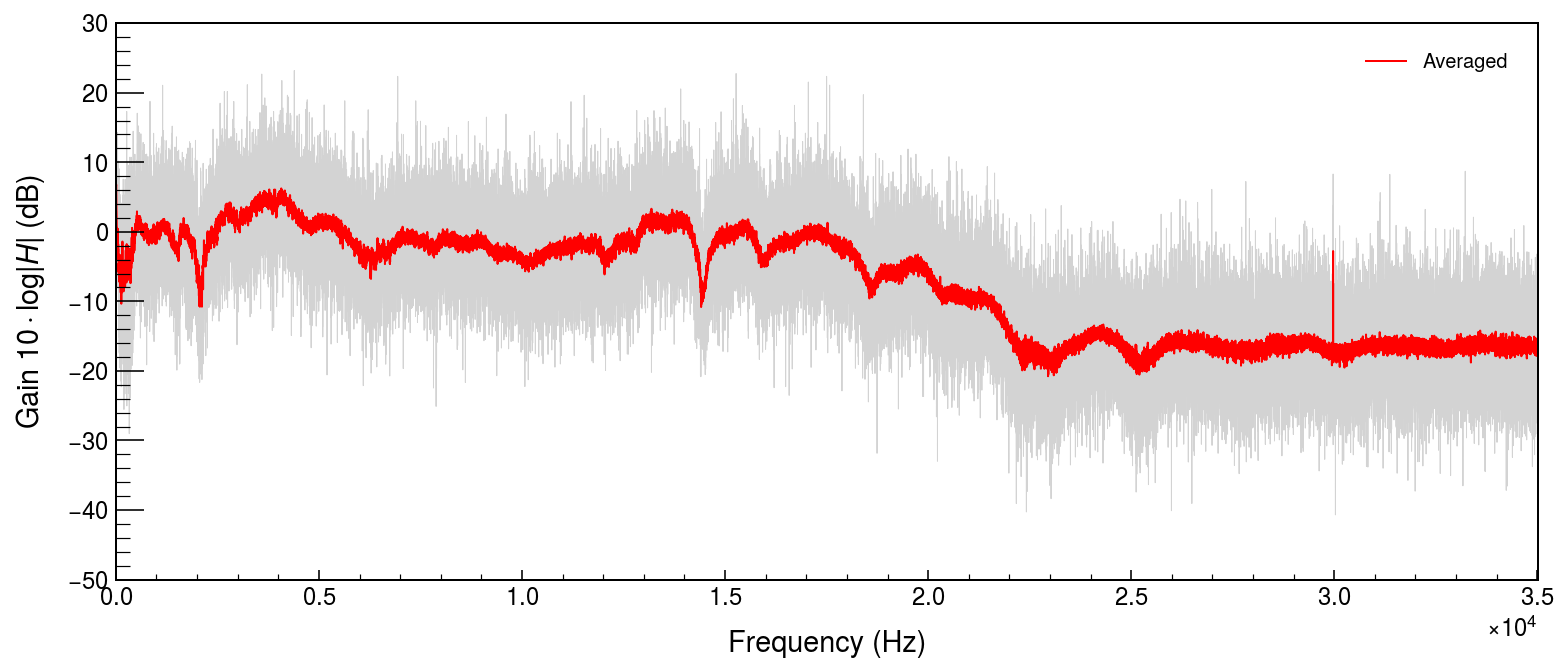

In [6]:
plt.figure(figsize=(12.5, 4.8))

for source, rec1 in zip(sources, recs1):
    plt.plot(source.fft().xindex, to_dB(rec1.fft().data / source.fft().data), 
             'lightgray', lw=0.5)

plt.plot(sources[0].fft().xindex, to_dB(TF1_avg), 
         'r', lw=1, label='Averaged')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain $10\cdot\log|H|$ (dB)')
plt.xlim(0, np.max(sources[0].fft().xindex))
plt.legend()

In [7]:
rec2_ffts = np.array([rec2.fft().data for rec2 in recs2]).mean(axis=0)
TF2_avg = rec2_ffts / source_ffts

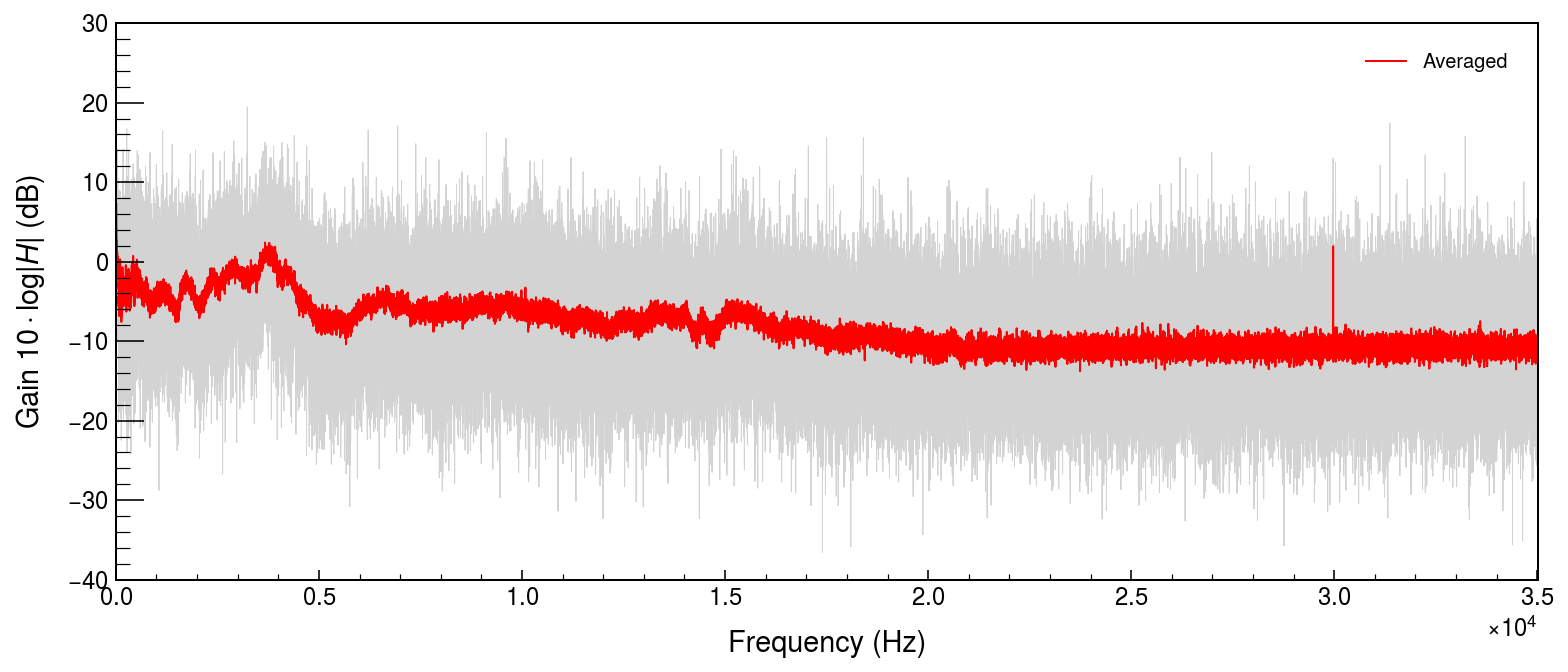

In [8]:
plt.figure(figsize=(12.5, 4.8))

for source, rec2 in zip(sources, recs2):
    plt.plot(source.fft().xindex, to_dB(rec2.fft().data / source.fft().data), 
             'lightgray', lw=0.5)

plt.plot(sources[0].fft().xindex, to_dB(TF2_avg), 
         'r', lw=1, label='Averaged')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain $10\cdot\log|H|$ (dB)')
plt.xlim(0, np.max(sources[0].fft().xindex))
plt.legend()

While computing the mean over the 0th-axis, the second receiver got moved from iths initial position so FFT Amplitude is not valid data, hence we can't have accurate frequency response for the amplifier/receiver system. 

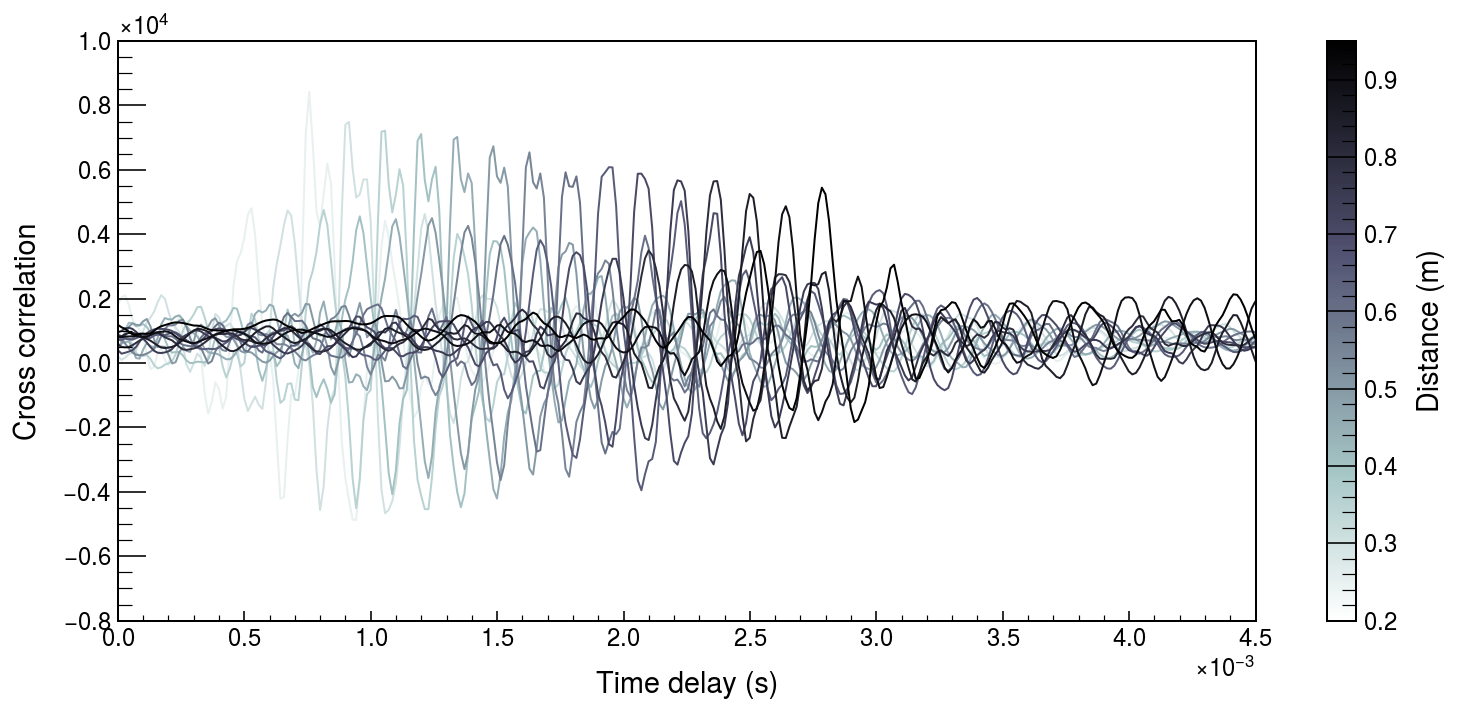

In [9]:
import matplotlib as mpl


fig, ax = plt.subplots(figsize=(12.5, 5))

delays = np.zeros_like(sources, dtype=float)
distances = np.array([rec1.header['distance'] for rec1 in recs1])
norm = plt.Normalize(distances.min(), distances.max())    

colors = plt.cm.bone_r

for idx, (rec1, rec2) in enumerate(zip(recs1, recs2)):
    lag, cross = rec2.correlate(rec1)
    ax.plot(lag, cross, color = colors(norm(rec1.header['distance'])), lw=1)
    
    delays[idx] = lag[np.argmax(cross)]

ax.set_xlim(0, 0.0045)
ax.set_ylabel('Cross correlation')
ax.set_xlabel('Time delay (s)')

fig.colorbar(plt.cm.ScalarMappable(cmap=colors, norm=norm), label='Distance (m)')

In [10]:
error_distance = 0.005

model = lambda x, p: x * p[0] + p[1]
fcn = LeastSquares(delays, distances, error_distance, model)
fcn.loss = 'soft_l1'
minimizer = Minuit(fcn, (343, 0))
minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.455 (chi2/ndof = 0.3)    │              Nfcn = 47               │
│ EDM = 7.33e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   344.5   │    2.3    │            │            │         │         │       │
│ 1 │ x1   │  -0.012   │   0.004   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │       x0       x1 │
├────┼───────────────────┤
│ x0 │     5.04  -0.0086 │
│ x1 │  -0.0086 1.67e-05 │
└────┴───────────────────┘

In [11]:
y, ycov = propagate(lambda p: model(delays, p), minimizer.values, minimizer.covariance)
yerr_prop = np.diag(ycov)**0.5

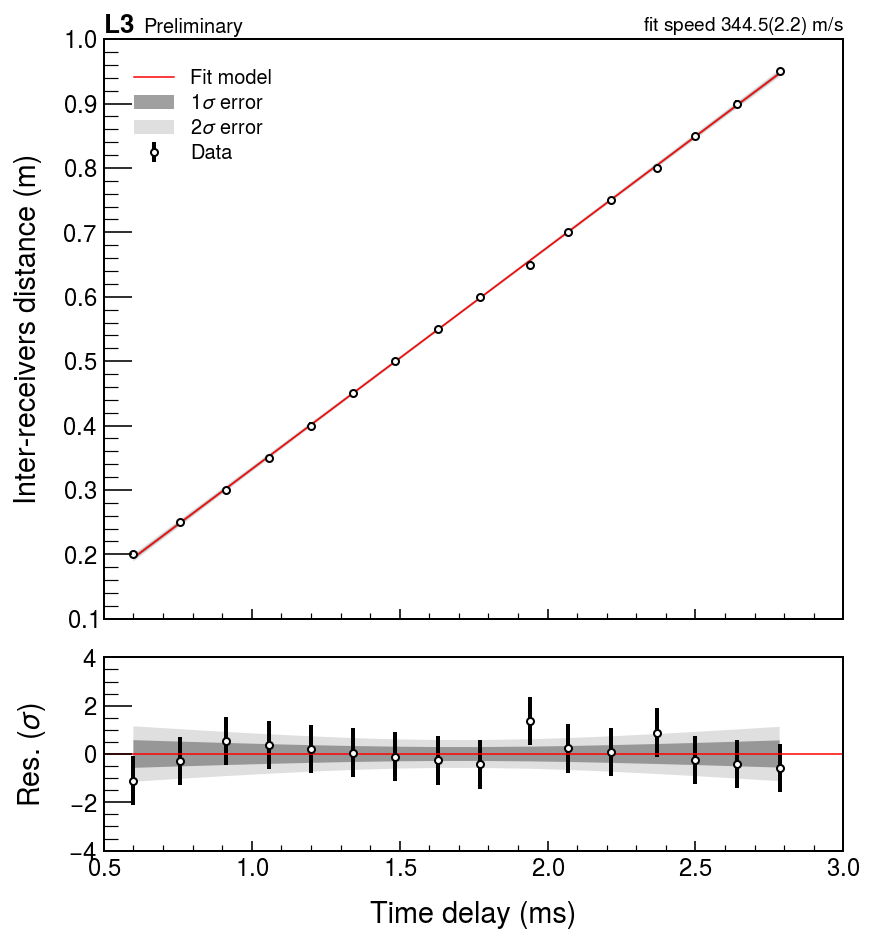

In [12]:
fig = plt.figure(figsize=(6.5,7))
grid = fig.add_gridspec(2,1,height_ratios=(3,1), hspace=0.1)
ax = fig.add_subplot(grid[0])


ax.errorbar(delays * 1e3, distances, yerr=error_distance, 
            fmt='k.', label='Data', markersize=7, mfc='w')
ax.plot(delays * 1e3, model(delays, minimizer.values), 'r', label='Fit model', lw=0.75)


ax.fill_between(delays * 1e3, y+yerr_prop, y-yerr_prop, 
                facecolor='gray', alpha=0.75, label='1$\sigma$ error')
ax.fill_between(delays * 1e3, y+2*yerr_prop, y-2*yerr_prop, 
                facecolor='gray', alpha=0.25, label='2$\sigma$ error')
ax.set_ylabel('Inter-receivers distance (m)')
hep.label.exp_text('L3 ', 'Preliminary')
hep.label.lumitext(
    f'fit speed ${ufloat(minimizer.values[0], minimizer.errors[0]):.uSL}$ m/s'
)
ax.tick_params(labelbottom=False)

resax = fig.add_subplot(grid[1], sharex=ax)

resax.errorbar(delays * 1e3, (y-distances)/error_distance, yerr=1, 
               fmt='k.', markersize=7, mfc='w')
resax.axhline(0, color='r', lw=0.75)


resax.fill_between(delays * 1e3, +yerr_prop/error_distance, -yerr_prop/error_distance, 
                   facecolor='gray', alpha=0.75)
resax.fill_between(delays * 1e3, +2*yerr_prop/error_distance, -2*yerr_prop/error_distance, 
                   facecolor='gray', alpha=0.25)
resax.set_xlabel('Time delay (ms)')
resax.set_ylabel('Res. ($\sigma$)')

ax.legend()
fig.savefig('plot.pdf', bbox_inches='tight')